In [11]:
# Run in Python 3.7 kernel
# Import libraries

import pandas as pd
import numpy as np # creating and manipulating arrays
import matplotlib.pyplot as plt # visualizing data
import sklearn # regression models
import statsmodels.api as sm 

1. Develop Linear Regression model using Statmodels

In [12]:
data = pd.read_csv("garments_worker_productivity.csv", header = 0) # read in data
data = pd.get_dummies(data, columns=["quarter","department","day","team"], drop_first=True) # create dummy variables for categorical data
data = data.dropna() # drop rows with NaN values
data = data.drop('date', axis=1) # drop dates
data_ols = sm.add_constant(data)
model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns!='actual_productivity']) # use actual productivity as the dependent variable, and everything else as independent
results = model.fit()
print(results.summary())

# Compile Significant Variables
sigparams = results.params[results.pvalues < 0.05] # Get significant variables
sigparams = sigparams.to_frame() # Create a dataframe of them
sigparams.columns = ['coefficient'] # Name the columns
sigparams = sigparams['coefficient'].astype(float) # Convert to float so that you can sort it by absolute value
sigparams = sigparams.sort_values(key=abs, ascending=False) # Order by absolute value

data_new = np.array([[0],[1],[2],[3],[4],[5],[6]]) #you'll use this later

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.805
Method:                  Least Squares   F-statistic:                     99.37
Date:                 Tue, 20 Sep 2022   Prob (F-statistic):          3.90e-219
Time:                         17:13:04   Log-Likelihood:                 889.27
No. Observations:                  691   AIC:                            -1719.
Df Residuals:                      661   BIC:                            -1582.
Df Model:                           29                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
targeted_productivit

2. Select the best features using forward selection

In [13]:
# Show significant parameters
print(sigparams)

targeted_productivity    0.621713
department_sweing        0.145683
team_11                 -0.043256
idle_men                -0.006253
smv                     -0.003984
incentive                0.003253
no_of_workers            0.002039
idle_time                0.000614
over_time               -0.000003
Name: coefficient, dtype: float64


Test Models

In [14]:
il = [] #create blank list to assign features to
for x in range(0, (sigparams.count())):
    if x == 0:
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns==sigparams.index[0]])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)
        il.append(sigparams.index[0])
    else:
        il.append(sigparams.index[x])
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[il])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)




[]
0.9773934809944065
['targeted_productivity', 'department_sweing']
0.4864174278778667
['targeted_productivity', 'department_sweing', 'team_11']
0.4859171427117741
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men']
0.5326273408778037
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv']
0.5530013010538016
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive']
0.792823221566805
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers']
0.7986647279602157
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time']
0.8011087556246014
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time', 'over_time']
0.8048791450397842


The model above with only targeted productivity in the model has an adjusted r-squared of 97.7%

However, since it is a target, not a metric, it isn't useful for predicting productivity, so we will remove it from the model.

In [15]:
sigparams = sigparams.drop('targeted_productivity')
print(sigparams)

department_sweing    0.145683
team_11             -0.043256
idle_men            -0.006253
smv                 -0.003984
incentive            0.003253
no_of_workers        0.002039
idle_time            0.000614
over_time           -0.000003
Name: coefficient, dtype: float64


Now we will re-run the analysis

In [16]:
il = []
for x in range(0, (sigparams.count())):
    if x == 0:
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns==sigparams.index[0]])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)
        il.append(sigparams.index[0])
    else:
        il.append(sigparams.index[x])
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[il])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)

[]
0.0
['department_sweing', 'team_11']
0.006763257386616206
['department_sweing', 'team_11', 'idle_men']
0.0733043559579889
['department_sweing', 'team_11', 'idle_men', 'smv']
0.10661507975692541
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive']
0.6693164460449099
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers']
0.6691637981027212
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time']
0.6699514156001276
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time', 'over_time']
0.6812456091514572


Every addition above increased the adjusted r squared value, except for no_of_workers.

Best features:
'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time'

3. Compare the performance of OLS and SGD implementation of linear model


I definitely messed something up here... tried adapting the model you gave us, but I think I changed something somewhere and can't find it again

In [17]:
#final OLS model
model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']])
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.682
Model:                             OLS   Adj. R-squared:                  0.680
Method:                  Least Squares   F-statistic:                     245.1
Date:                 Tue, 20 Sep 2022   Prob (F-statistic):          1.09e-166
Time:                         17:13:04   Log-Likelihood:                 705.61
No. Observations:                  691   AIC:                            -1397.
Df Residuals:                      684   BIC:                            -1365.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
department_sweing     0.6141

In [18]:
data_new_ols = sm.add_constant(data_new)
print(data_new_ols)
ols_output = results.get_prediction(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']]).summary_frame(alpha=0.05)

ols_output_list = ols_output['mean'].tolist()
ols_output_list

[[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]
 [1. 6.]]


[0.9548347158251089,
 0.7400002289892044,
 0.7912015501388202,
 0.774607407665501,
 0.6947070288548702,
 0.7203346901081642,
 0.69233637459345,
 0.7203346901081642,
 0.7159570875940315,
 0.7387778394178752,
 0.7912015501388202,
 0.5296653291556659,
 0.7456438462589571,
 0.7442753888269051,
 0.7447097951467438,
 0.8016186278304677,
 0.72013372771351,
 0.7713350488631259,
 0.7472382590244616,
 0.6947070288548702,
 0.7869314670733338,
 0.7370688586687788,
 0.4920327497742368,
 0.6984466775375011,
 0.7719337489896486,
 0.7884858202880698,
 0.7893037123757226,
 0.7250081320957855,
 0.7572757344313987,
 0.8016186278304677,
 0.7435911601108791,
 0.7719337489896486,
 0.6875765182682592,
 0.7370688586687788,
 0.6984466775375011,
 0.6046299346571532,
 0.8541498580000589,
 0.7468961446664486,
 0.6943649144968572,
 0.8016186278304677,
 0.719043732863286,
 0.7706508201471,
 0.7706508201471,
 0.7422227026788272,
 0.7422227026788272,
 0.7196504613921382,
 0.7370688586687788,
 0.6348477979423219,
 0.8

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [20]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']], data_ols.actual_productivity)

y_pred = reg.predict(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']])
y_pred

array([0.95532699, 0.73708004, 0.79235795, 0.77543613, 0.69573338,
       0.72125759, 0.69350756, 0.72125759, 0.71688891, 0.73987129,
       0.79235795, 0.5310849 , 0.7465108 , 0.74514687, 0.74563053,
       0.80242332, 0.71727396, 0.77255187, 0.74815749, 0.69573338,
       0.78792672, 0.73815317, 0.49357678, 0.69941421, 0.77314859,
       0.78931729, 0.79013934, 0.72597313, 0.75810422, 0.80242332,
       0.7444649 , 0.77314859, 0.68459337, 0.73815317, 0.69941421,
       0.60536561, 0.85484743, 0.74781651, 0.6953924 , 0.80242332,
       0.71598427, 0.77186991, 0.77186991, 0.74310097, 0.74310097,
       0.72057562, 0.73815317, 0.63609234, 0.83472944, 0.83472944,
       0.72349445, 0.72349445, 0.74124249, 0.78261087, 0.67612686,
       0.67612686, 0.73496052, 0.70062812, 0.66515734, 0.66873945,
       0.83472944, 0.83472944, 0.77223774, 0.78028724, 0.72349445,
       0.78195797, 0.74124249, 0.78056497, 0.72855098, 0.80547635,
       0.69467462, 0.62014866, 0.89152223, 0.83472944, 0.83168

NameError: name 'output' is not defined

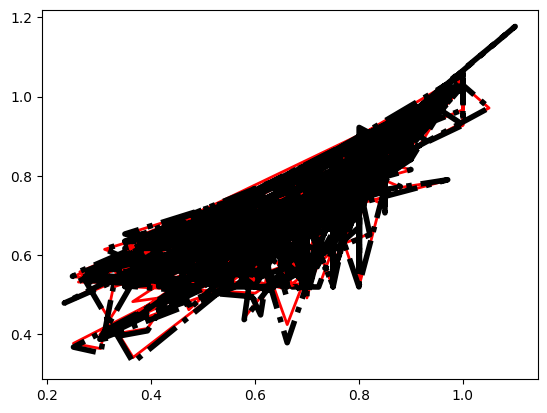

In [32]:
plt.plot(data['actual_productivity'], ols_output_list, "r-", linewidth=2, label="Statmodels Predictions")
#plt.plot(data_new, sk_output, "g-", linestyle='dashed',  linewidth=2, label="Sklearn Predictions")
plt.plot(data['actual_productivity'], y_pred, "black", linestyle='dashdot',  linewidth=4, label="SGDRegressor Predictions")


plt.plot(data, output, "b.")
plt.legend(loc="upper left", fontsize=14)
plt.show()

4.